In [1]:
from collections import Counter
from datetime import datetime
import json

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle
from IntegratedGradients import *
from matplotlib import pyplot as plt
import numpy as np
caleb_path = '/Users/CalebKaijiLu/Documents/yelp_dataset/'
selva_path = ''

Using TensorFlow backend.


In [4]:
def word_to_embedding(embeddings,data):
    N = embeddings.shape[0]
    M = embeddings.shape[1]
    embeddings_aug = np.zeros([N+1,M])
    embeddings_aug[1:,:]=embeddings
    return embeddings_aug[np.array(data)]

In [3]:

t1 = datetime.now()
with open(caleb_path + "review.json") as f:
    reviews = f.read(int(1e7)).strip().split("\n")
reviews = reviews[:10000]
reviews = [json.loads(review) for review in reviews]
print(datetime.now() - t1)

0:00:00.220188


In [4]:
# Get a balanced sample of positive and negative reviews
texts = [review['text'] for review in reviews]

# Convert our 5 classes into 2 (negative or positive)
binstars = [0 if review['stars'] <= 3 else 1 for review in reviews]
balanced_texts = []
balanced_labels = []
limit = 1000  #Change this to grow/shrink the dataset
neg_pos_counts = [0, 0]
for i in range(len(texts)):
    polarity = binstars[i]
    if neg_pos_counts[polarity]<limit:
        balanced_texts.append(texts[i])
        balanced_labels.append(binstars[i])
        neg_pos_counts[polarity]+=1

In [5]:
Counter(balanced_labels)

Counter({0: 1000, 1: 1000})

In [12]:
tokenizer = Tokenizer(num_words=5)
toytexts = ["Is is a common word", "So is the", "the is common", "discombobulation is not common"]
tokenizer.fit_on_texts(toytexts)
print(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(toytexts)


# >>> [[1, 1, 4, 2], [1, 3], [3, 1, 2], [1, 2]]

{'is': 1, 'common': 2, 'the': 3, 'a': 4, 'word': 5, 'so': 6, 'discombobulation': 7, 'not': 8}


In [7]:
print(sequences)
# >>> [[1, 1, 4, 2], [1, 3], [3, 1, 2], [1, 2]]

[[1, 1, 4, 2], [1, 3], [3, 1, 2], [1, 2]]


In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=300)

In [9]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=300))
# model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(data, np.array(balanced_labels), validation_split=0.5, epochs=6)

Train on 1000 samples, validate on 1000 samples
Epoch 1/6
1000/1000 [==============================] - 16s - loss: 0.5985 - acc: 0.7040 - val_loss: 1.0563 - val_acc: 0.2780
Epoch 2/6
1000/1000 [==============================] - 19s - loss: 0.4869 - acc: 0.7220 - val_loss: 1.1755 - val_acc: 0.2820
Epoch 3/6
1000/1000 [==============================] - 15s - loss: 0.2064 - acc: 0.9170 - val_loss: 0.7994 - val_acc: 0.6480
Epoch 4/6
1000/1000 [==============================] - 14s - loss: 0.0470 - acc: 0.9900 - val_loss: 1.5380 - val_acc: 0.5360
Epoch 5/6
1000/1000 [==============================] - 15s - loss: 0.0206 - acc: 0.9970 - val_loss: 1.2485 - val_acc: 0.6360
Epoch 6/6
1000/1000 [==============================] - 14s - loss: 0.0048 - acc: 0.9990 - val_loss: 1.6070 - val_acc: 0.5900


In [11]:
# save the tokenizer and model
with open("keras_tokenizer.pickle", "wb") as f:
        pickle.dump(tokenizer, f)
model.save("yelp_sentiment_model.hdf5")

In [ ]:
for i in model.model.inputs:
    print(i)
print(range(model.model.output.shape[1]._value))
for i in range(model.model.output.shape[1]._value):
    print(i)
print(model.model.inputs)
print(model.model.output[:,0].shape)
print(dir(model.model.optimizer))
print(model.model.optimizer.get_gradients(model.model.output[:,0],model.model.layers[1].output))

In [ ]:
np.shape(model.output)
np.shape(data)
np.shape(np.array(balanced_labels))

In [ ]:
input_tensors = []
input_tensors.append(model.model.layers[1].output)
# The learning phase flag is a bool tensor (0 = test, 1 = train)
# to be passed as input to any Keras function that uses 
# a different behavior at train time and test time.
input_tensors.append(K.learning_phase())
print(np.shape(input_tensors))

gradients = model.model.optimizer.get_gradients(model.model.output[:,0],model.model.layers[1].output)
print(gradients)
print(range(model.model.output.shape[1]._value))
print (K.function(inputs=input_tensors, outputs=gradients))

In [2]:
# load the tokenizer and the model
with open("keras_tokenizer_server.pickle", "rb") as f:
       tokenizer = pickle.load(f)

model = load_model("yelp_sentiment_model_server.hdf5")

[[ 0.02246372]]
['i', 'went', 'with', 'my', 'friend', 'after', 'shcool', 'really', 'hate', 'the', 'bread', 'tastes', 'awful']
(2,)
Evaluated output channel (0-based index): All
Building gradient functions
[<tf.Tensor 'embedding_3/Gather:0' shape=(?, 300, 128) dtype=float32>, <tf.Tensor 'keras_learning_phase:0' shape=<unknown> dtype=bool>] [<tf.Tensor 'gradients_23/AddN_7:0' shape=(?, 300, 128) dtype=float32>]
Progress: 100.0%
Done.
Haha
(50, 300, 128)
1
[288 289 290 291 292 293 294 295 296 297 298 299]
(12,)


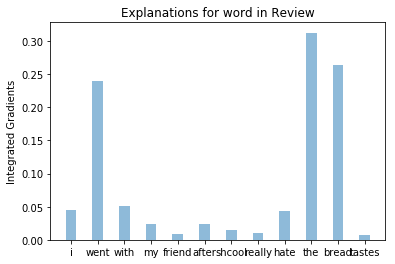

In [31]:
# replace with the data you want to classify
newtexts = ["I went with my friend after shcool, really hate the bread,tastes awful"]
word_sequences = text_to_word_sequence(newtexts[0])
# note that we shouldn't call "fit" on the tokenizer again
sequences = tokenizer.texts_to_sequences(newtexts)
data = pad_sequences(sequences, maxlen=300)

# get predictions for each of your new texts
predictions = model.predict(data)
print(predictions)
print(word_sequences)

embeddings = model.layers[0].get_weights()[0]
word_embeddings = word_to_embedding(embeddings,data)
ig = integrated_gradients(model)
explanations = ig.explain(word_to_embedding(embeddings,data))
print(len(explanations))
final_explanations = np.abs(np.sum(explanations[0],axis = 1))
print(np.where(final_explanations!=0)[0])
final_explanations = final_explanations[np.where(final_explanations!=0)]
print(final_explanations.shape)
y_pos = np.arange(0,2*len(final_explanations),2)
plt.bar(y_pos,final_explanations,align='center', alpha=0.5)
plt.xticks(y_pos, word_sequences)
plt.ylabel('Integrated Gradients')
plt.title('Explanations for word in Review')
plt.show()